In [413]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
plt.style.use("ggplot")
df_raw=yf.download("BTC-USD",progress=False)

# PERIOD

In [498]:

year_start = '2019'
year_end = '2020'
df = df_raw.loc[f'{year_start}-01-01':f'{year_end}-01-01']
# df = df_raw.loc[:df_raw.index[-1]]

# INDICATORS

In [499]:
#MOVING AVG
df["SMA21"]=df["Close"].rolling(21).mean()
df["SMA9"]=df["Close"].rolling(9).mean()
df["SMA30"]=df["Close"].rolling(30).mean()
df["SMA5"]=df["Close"].rolling(5).mean()
df["SMA15"]=df["Close"].rolling(15).mean()
df["SMA10"]=df["Close"].rolling(10).mean()
df["Relation"]=df["SMA5"]/df["SMA15"]

#BOLLINGER
df["SMA20"]=df["Close"].rolling(20).mean()
df["stdClose20"]=df["Close"].rolling(20).std()

#RSI
df["Diff"]=df["Close"].diff(1)
df["Positive"]=df["Diff"]
df["Negative"]=df["Diff"]
df.loc[df["Diff"]<0,"Positive"]=0
df.loc[df["Diff"]>0,"Negative"]=0
df["Negative"]=abs(df["Negative"])
df["PosSum20"]=df["Positive"].rolling(14).sum()
df["NegSum20"]=df["Negative"].rolling(14).sum()
df["RSI"]=100-100/(1+(df["PosSum20"]/df["NegSum20"]))
prev=None
for i in df.index:
    if(prev!=None):
        condition1=((df.loc[df.index==prev, "RSI"].values[0]<70) and (df.loc[df.index==i, "RSI"].values[0]>=70))
        condition2=((df.loc[df.index==prev, "RSI"].values[0]>30) and (df.loc[df.index==i, "RSI"].values[0]<=30))
        df.loc[i, "transp"] = 0
        df.loc[i, "3070POINTS"] = "blue"
        if condition1: df.loc[i, "3070POINTS"] = "red"  #top
        if condition1: df.loc[i, "transp"] = 1  #top
        if condition2: df.loc[i, "3070POINTS"] = "green"  #bottom
        if condition2: df.loc[i, "transp"] = 1  #bottom
    else:
        df.loc[i, "transp"] = 0
        df.loc[i, "3070POINTS"] = "blue"
    prev=i

df = df.dropna()


<ipython-input-499-7de9e7beeaba>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-499-7de9e7beeaba>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-499-7de9e7beeaba>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-499-7de

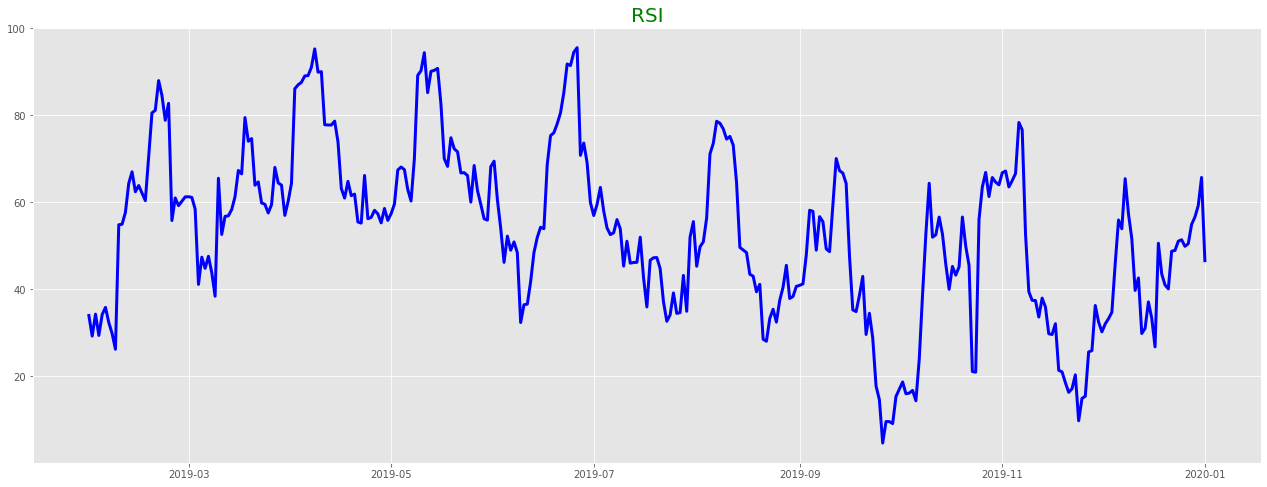

In [500]:
plt.figure(figsize=(22,8))
plt.plot(df["RSI"],color="blue",linewidth=3)
plt.title("RSI",fontsize=20,color="green")

plt.show()

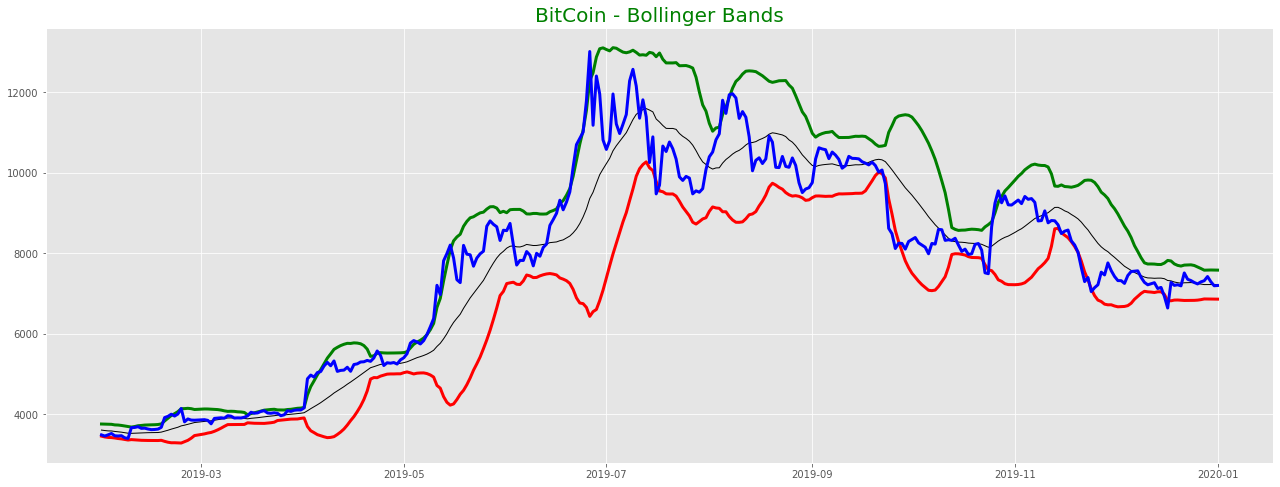

In [501]:
plt.figure(figsize=(22,8))
plt.plot(df["SMA20"]+2*df["stdClose20"],color="green",linewidth=3)
plt.plot(df["SMA20"]-2*df["stdClose20"],color="red",linewidth=3)
plt.plot(df["SMA20"],color="black",linewidth=1)
plt.plot(df["Close"],color="blue",linewidth=3)
plt.title("BitCoin - Bollinger Bands",fontsize=20,color="green")

plt.show()

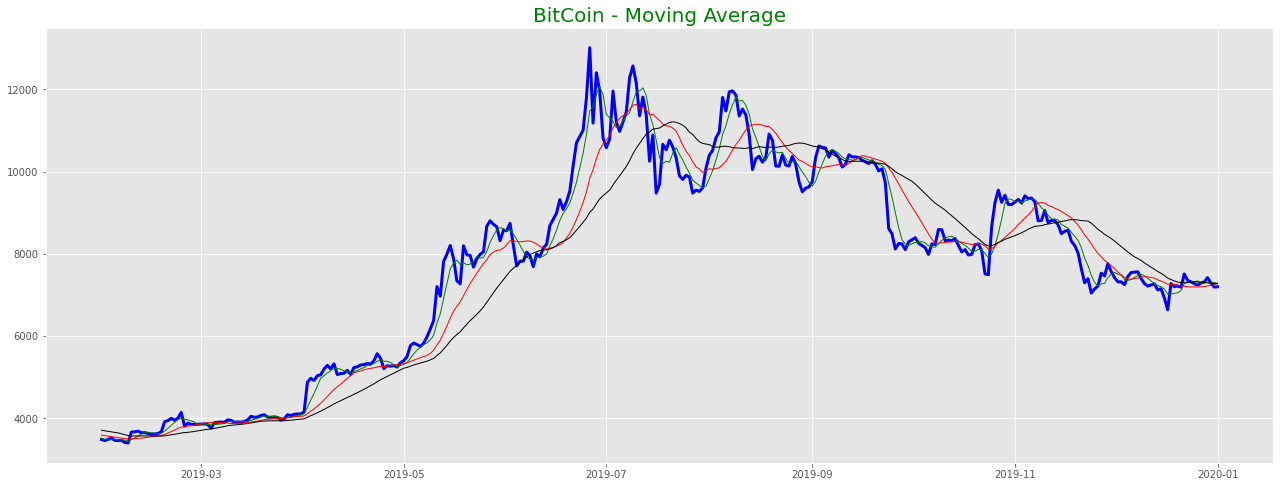

In [516]:
plt.figure(figsize=(22,8))
plt.plot(df["Close"],color="blue",linewidth=3)
plt.plot(df["SMA5"],color="green",linewidth=1)
plt.plot(df["SMA15"],color="red",linewidth=1)
plt.plot(df["SMA30"],color="black",linewidth=1)
plt.title("BitCoin - Moving Average",fontsize=20,color="green")

plt.show()

# STRATEGY

In [503]:
# Comission is 1% of total value traded


Buy, Sell = [],[]
df_log=pd.DataFrame()
signal=0
initial_cash=1000000
cash=initial_cash
amount=cash
cash_data=[] # keeps track of total capital
orders=0
stop_value=None
for i in range(len(df["Close"])):

    # Buy Strategy
    if (df["Relation"].iloc[i]>1.02) and signal==0:
        signal+=1
        Buy.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        maximo=math.trunc((cash/(df["Open"].iloc[i+1]+comission)))
        cash-=maximo*(df["Open"].iloc[i+1]+comission)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Buy",df.index[i+1],price,maximo,price*maximo,comission,maximo*comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)
        orders+=1
        stop_value=df["Open"].iloc[i+1]*0.8


    # Sell strategy
    if (df["Relation"].iloc[i]<0.98) and signal==1:
        signal=0
        Sell.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        cash+=maximo*(df["Open"].iloc[i+1]-comission)
        # cash_data.append(cash)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Sell",df.index[i+1],price,maximo,price*maximo,comission,maximo*comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)  
        orders+=1

    if stop_value!=None:
        if stop_value>df["Open"].iloc[i] and signal==1:
            signal=0
            Sell.append(i)
            comission=0.01*df["Open"].iloc[i+1]
            cash+=maximo*(df["Open"].iloc[i+1]-comission)
            # cash_data.append(cash)
            price=(df["Open"].iloc[i+1])
            a_row=pd.Series(["Sell",df.index[i+1],price,maximo,price*maximo,comission,maximo*comission])
            row_df=pd.DataFrame([a_row])
            df_log = pd.concat([row_df, df_log], ignore_index=True)
            orders+=1

    if signal==1:
        stop_value=df["Open"].iloc[i]*0.95
        if(i<len(df["Close"])-1):
            cash_data.append(cash+maximo*(df["Open"].iloc[i+1]))
        else:
            cash_data.append(cash+maximo*(df["Close"].iloc[i]))
    else:
        cash_data.append(cash)
    
    

In [504]:
df_log=df_log[::-1]
df_log=df_log.rename(columns={0:"Type",1:"Date",2:"Price",3:"Quantity",4:"Total",5:"Comissions", 6:"Total Comissions"})
df_log=df_log.set_index("Date")

# BUY&HOLD

In [505]:
buy_hold=[]
datas_buy_hold=[]
shares=df_log["Quantity"][0]
for a in range(len(df)):
    buy_hold.append(df["Close"].iloc[a]*shares)
    datas_buy_hold.append(df.index[a])
minimo_buy_hold=min(buy_hold)
buy_hold=pd.DataFrame(pd.Series(buy_hold))
datas_buy_hold=pd.DataFrame(pd.Series(datas_buy_hold))
buy_hold["Datas"]=datas_buy_hold
buy_hold=buy_hold.set_index("Datas")

# STRATEGY RESULTS DATAFRAME

In [506]:
cash_data_data=df.index
cash_df = pd.DataFrame(pd.Series(cash_data_data))
cash_data = cash_data
cash_df = cash_df.assign(Cash=cash_data)
cash_df = cash_df.set_index("Date")
cash_df
min_budget=min(cash_data)

In [507]:
# SELLING POINTS ONLY

# min_budget=min(cash_data)
# current_buy=cash+df_log["Quantity"].iloc[-1]*df["Open"].iloc[-1]
# cash_data.append(current_buy)
# cash_data=pd.DataFrame(pd.Series(cash_data, name="Amount"))
# t_f=df_log["Type"]=="Sell"
# cash_data_data=df_log[t_f]
# cash_data_data=cash_data_data.index.tolist()
# cash_data_data.append(df.index[0])
# cash_data_data.append(df.index[-1])
# cash_data_data.sort()
# cash_data_data=pd.DataFrame(pd.Series(cash_data_data))
# cash_data["Dates"]=cash_data_data
# cash_data=cash_data.set_index("Dates")

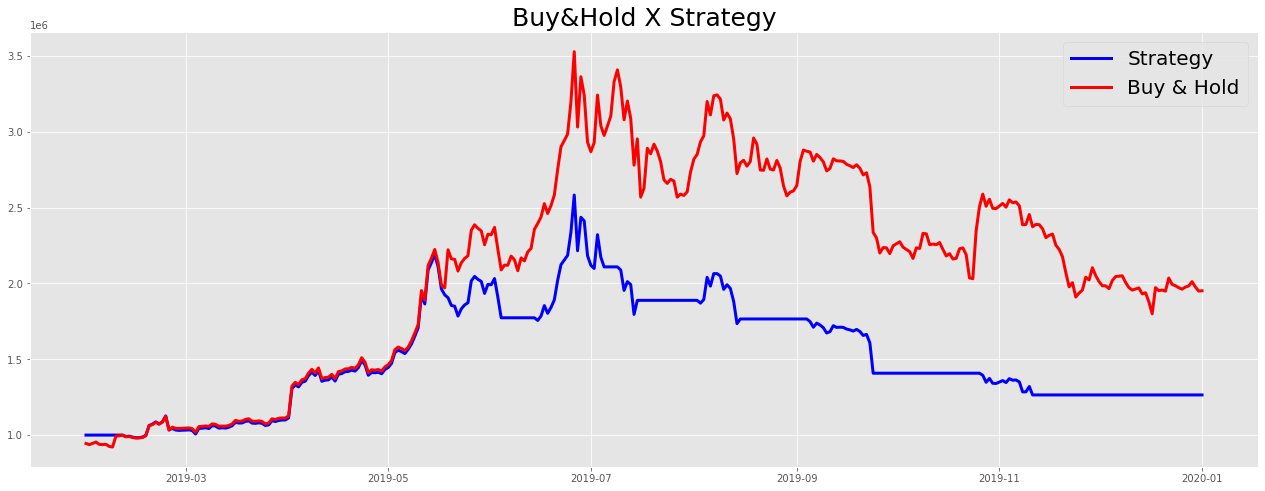

In [513]:
plt.figure(figsize=(22,8))
plt.plot(cash_df,color="blue",label="Strategy",linewidth=3)
plt.plot(buy_hold,color="red",label="Buy & Hold",linewidth=3)
plt.title("Buy&Hold X Strategy",fontsize=25)
plt.legend(fontsize=20)
plt.show()

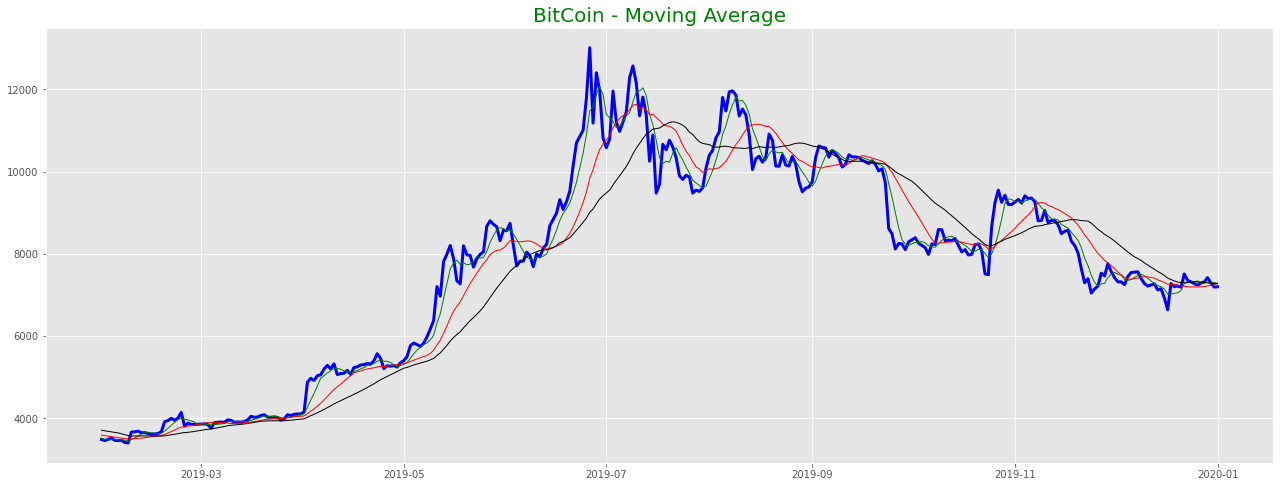

In [514]:
plt.figure(figsize=(22,8))
plt.plot(df["Close"],color="blue",linewidth=3)
plt.plot(df["SMA5"],color="green",linewidth=1)
plt.plot(df["SMA15"],color="red",linewidth=1)
plt.plot(df["SMA30"],color="black",linewidth=1)
plt.title("BitCoin - Moving Average",fontsize=20,color="green")

plt.show()

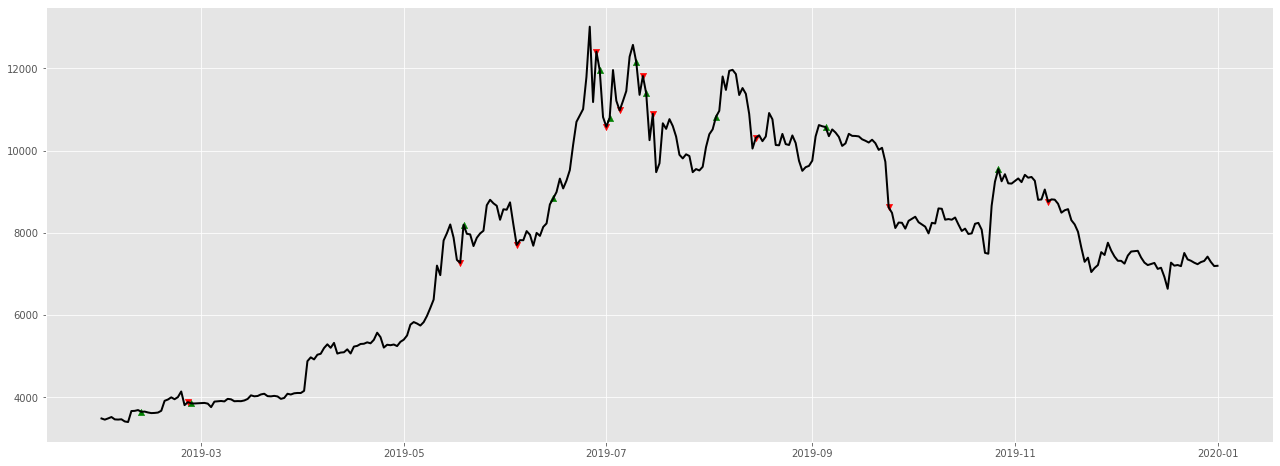

In [509]:
plt.figure(figsize=(22,8))
plt.scatter(df.iloc[Buy].index, df.iloc[Buy]["Adj Close"], marker="^", color="green",s=40)
plt.scatter(df.iloc[Sell].index, df.iloc[Sell]["Adj Close"], marker="v", color="red",s=40)
plt.plot(df["Adj Close"], label="Price", color="k",linewidth =2)

In [510]:
print(f"Period: {df.index.day[0]}/{df.index.month[0]}/{df.index.year[0]} - {df.index.day[-1]}/{df.index.month[-1]}/{df.index.year[-1]}")
print("-="*15)
print(f'{cash_df.iloc[-2][0]:.2f}')
strategy_return=cash_df.iloc[-2][0]/cash_df.iloc[0][0].round(2)
print(f"Strategy Total Return: {(cash_df.iloc[-2][0]/cash_df.iloc[0][0])*100:.2f}%")
x=df["Close"][-1]/df["Close"][0]
print(f"Buy & Hold Total Return {(x*100):.2f}% ")
print("-="*15)
print(f"Strategy Annual Return: {(((1+strategy_return)**(252/len(df))-1)*100):.2f}%")
print(f"Buy & Hold Annual Return: {(((1+x)**(252/len(df))-1)*100):.2f}%")
print("-="*15)
print(f"Orders: {orders}")
print(f"Orders/Year: {orders/(len(df)/252)}")
print("-="*15)
print(f"Maximum Strategy drawdown: {(((min_budget-amount)/amount)*100):.2f}%")
print(f"Maximum Buy & Hold drawdown: {(((min(buy_hold[0])-amount)/amount)*100)}%")

Period: 30/1/2019 - 1/1/2020
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
1264647.98
Strategy Total Return: 126.46%
Buy & Hold Total Return 206.53% 
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Strategy Annual Return: 84.27%
Buy & Hold Annual Return: 131.09%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Orders: 22
Orders/Year: 16.451038575667656
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Maximum Strategy drawdown: -1.73%
Maximum Buy & Hold drawdown: -7.87431748046875%


In [ ]:
import vectorbt as vbt

price = vbt.YFData.download('BTC-USD', interval="1d").get('Close')

In [ ]:


pf = vbt.Portfolio.from_holding(price, init_cash=1000)
pf.plot()


In [ ]:
pf.total_profit()

In [ ]:
Sma20 = vbt.MA.run(price, 20)
Sma10 = vbt.MA.run(price, 10)
buy = Sma10.ma_above(Sma20)
sell = Sma20.ma_above(Sma10)


In [ ]:
pf = vbt.Portfolio.from_signals(price, buy, sell, sl_stop=0.005)

In [ ]:
pf.plot()

In [ ]:
pf.total_profit()

In [ ]:
pf = vbt.Portfolio.from_signals(price, buy, sell)

In [ ]:
pf.plot()

In [ ]:
pf.total_profit()